# **Credit Card Fraud Detection using MCMC Methods**
The dataset is collected from Kaggle. It is a real-world data, it contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, the original features and more background information about the data are not provided.
However, here I will try to explore MCMC methods by using this dataset and the runtime of MCMC methods is very delayed therefore, I would choose only minimum important features as predictors.

Further, to implement different distributions, below is a compact explanation which could help me to choose a reference distribution.
distribution:

- **Uniform Distribution:** The uniform distribution defines equal probability over a given range for a continuous distribution. For this reason, it is important as a reference distribution(prior decision).

- **Normal Distribution:** also known as the Gaussian distribution, it is symmetric, unimodal, and asymptotic, and the mean, median, and mode are all equal. A normal distribution is perfectly symmetrical around its center. That is, the right side of the center is a mirror image of the left side.

- **Half-normal Distribution:** It is a Normal distribution truncated to only have nonzero probability density for values greater than or equal to the location of the peak.

- **Skew-normal Distribution:** If one tail is longer than another, the distribution is skewed. It can be either left or right skewed and the mean will be shifted to either side of the median.

- **Dirichlet Distribution:** The Dirichlet distribution is the conjugate prior distribution of the categorical distribution (a generic discrete probability distribution with a given number of possible outcomes) and multinomial distribution (the distribution over observed counts of each possible category in a set of categorically distributed observations). This means that if a data point has either a categorical or multinomial distribution.

- **Beta Distribution:** Applied to model the behavior of random variables limited to intervals of finite length in a wide variety of disciplines. It is the conjugate prior probability distribution for the Bernoulli, binomial, negative binomial and geometric distributions. Also, it is a suitable model for the random behavior of percentages and proportions.

- **Categorical Distribution:** It is a discrete probability distribution that describes the possible results of a random variable that can take on one of K possible categories, with the probability of each category separately specified.

- **GLM Distribution:** Some common GLM families are Gaussian, Binomial, Poisson, Gamma and Inverse-Gamma. The GLM generalizes linear regression by allowing the linear model to be related to the response variable via a link function and by allowing the magnitude of the variance of each measurement to be a function of its predicted value.

- **Binomial Distribution:** The binomial is a type of distribution that has two possible outcomes for e.g., success or failure. It summarizes the likelihood that a value will take one of two independent values under a given set of parameters or assumptions. Also, there is only one outcome for each trial, with same probability of success, and independent of one another.

- **Negative Binomial Distribution:** has very similar characteristics to the Poisson distribution except that it has two parameters (𝜇 and 𝛼) which enables it to vary its variance independently of its mean.

- **Poisson Distribution:** is generally used to describe the probability of a given number of events occurring on a fixed time/space interval.

Below is the explanantion of MCMC Sampling methods that are commonly used using **PyMC** library:

- **NUTS:** NUTS uses a recursive algorithm to build a set of likely candidate points that spans a wide swath of the target distribution, stopping automatically when it starts to double back and retrace its steps.

- **Metropolis Hastings:** An algorithm is a MCMC method for obtaining a sequence of random samples by random walk from a probability distribution from which direct sampling is difficult.

- **Hamiltonian MonteCarlo:** obtains a sequence of random samples which converge to being distributed according to a target probability distribution. It reduces the correlation between successive sampled states by proposing moves to distant states which maintain a high probability of acceptance due to the approximate energy conserving properties.

- **CategoricalGibbsMetropolis:** The Gibbs Sampling is a Monte Carlo Markov Chain method that iteratively draws an instance from the distribution of each variable, conditional on the current values of the other variables in order to estimate complex joint distributions. It always accept the proposal. A Metropolis-within-Gibbs step method optimized for categorical variables. Step method supports two types of proposals: A uniform proposal and a proportional proposal.

Now let's get started...

## **Import Libraries**

In [ ]:
# importing libraries
import numpy as np
import scipy
import scipy.stats
import matplotlib as mpl   
import matplotlib.pyplot as plt
import os
import csv
import arviz as az
import seaborn as sns
sns_c = sns.color_palette(palette='deep')

import pandas as pd
from sklearn import preprocessing
import theano as T

import math 
import itertools
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import pymc3 as pm
import pymc3.distributions.continuous as pmc
import pymc3.distributions.discrete as pmd
import pymc3.math as pmm

from sklearn.model_selection import train_test_split


import json
# s = json.load(open('../style/bmh_matplotlibrc.json'))
# matplotlib.rcParams.update(s)
# matplotlib.rcParams['figure.figsize'] = (10, 3)
# matplotlib.rcParams['font.size'] = 14
# matplotlib.rcParams['ytick.major.size'] = 20


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## **Fetch Data**

* In this section, I have read data from csv file and convert it into pandas Dataframe. Headers will be removed and we know that 28 out of the 31 columns are unlabelled. 
* The labelled columns are Time, Amount and Class(to be predicted variable).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
filename = "/content/drive/MyDrive/Colab Notebooks/ML-2/Project/creditcard.csv"


Mounted at /content/drive


In [ ]:
# read data from csv file
data = read_csv(filename)
df = pd.DataFrame(data)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


## **Helper Functions**

In [ ]:
# Loading dataset creditcard
def read_csv(filename):
  with open(filename, 'r') as f:
    reader=csv.reader(f, delimiter=',') 
    labels=next(reader)

    raw_data=[]
    for row in reader:
        raw_data.append(row)

  data = np.array(raw_data)
  data = data.astype(np.float)
  return data

def logistic(l):
  # x = np.random.randn(100)
  # x_shared = T.shared(x)
  # return x_shared*l
  return 1 / (1 + T.tensor.exp(-l))

# def logistic(x=x, beta=beta):
#     return 1.0 / (1. + np.exp(beta * x))

def view_distribution(data):
  az.plot_kde(data, rug=True)
  return plt.yticks([0], alpha=0)

def get_scaled_df(df,cols):
  rob_sc = preprocessing.RobustScaler()
# df2= df.copy(deep=True)
  scaled_time = rob_sc.fit_transform(df[cols[0]].values.reshape(-1,1))
  scaled_amount = rob_sc.fit_transform(df[cols[1]].values.reshape(-1,1))
  # Amount and Time are Scaled so we are removing unsacled features!
  df.drop(cols, axis=1, inplace=True)
  df.insert(cols[0],'Time',value=scaled_time)
  df.insert(cols[1],'Amount',value=scaled_amount)
  return df

def run_ppc(model_, trace_, y_obs, thetas):
  with model_:
    
    forecast_1 = az.from_pymc3(
        posterior_predictive=pm.sample_posterior_predictive(trace=trace_))
    posterior_samples = forecast_1.posterior_predictive['y_obs'].values.flatten()

  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
  sns.countplot(x=thetas, color=sns_c[0], ax=ax[0])
  ax[0].set(title='Sample Distribution', xlabel='y', xlim=(-1, 10))
  sns.countplot(x=posterior_samples, color=sns_c[2], ax=ax[1])
  ax[1].set(title='Posterior Predictive Distribution', xlabel='y', xlim=(-1, 10));

  return forecast_1, posterior_samples

In [ ]:
def plots(trace):    
    # az.plot_trace(data=trace);
    az.summary(trace)
    
    #typical trace plots
    print("trace plot")
    pm.plot_trace(trace)
    
    #check if your posteriors look reasonable
    print("posterior plot")
    pm.plot_posterior(trace)
    
    # check if your variables have reasonable credible intervals, 
    #and Gelman–Rubin scores close to 1
    print("forest plot")
    pm.plot_forest(trace)
    
    #check if your chains are impaired by high autocorrelation. 
    #Also remember that thinning your chains is a waste of time at best, and deluding yourself at worst.
    print("autocorr plot")
    pm.plot_autocorr(trace)
    
    # ideally the energy and marginal energy distributions should look very similar. 
    # Long tails in the distribution of energy levels indicates deteriorated sampler efficiency.
    pm.energyplot(trace)

    # pm.plot_ppc(trace)

    #a souped-up version of pm.plot_posterior. 
    #It doesn’t seem to be wildly useful unless you’re plotting posteriors from multiple models.
    print("density plot")
    pm.plot_density(trace)
    
    # Display the total number and percentage of divergent chains
    # diverging = trace['diverging']
    # print('Number of Divergent Chains: {}'.format(diverging.nonzero()[0].size))
    # diverging_pct = diverging.nonzero()[0].size / len(trace) * 100
    # print('Percentage of Divergent Chains: {:.1f}'.format(diverging_pct))
    
    # az.plot_pair(trace, 
    #              var_names=['p','p'], 
    #              kind='kde', 
    #              group="posterior",
    #              divergences=True,
    #              colorbar=True,
    #              divergences_kwargs={'color': 'C2'})

In [ ]:

# columns to convert to date format
def change_type_to_date(df, to_date):
  # Deal with incorrect data in date column
  for i in to_date:
    df[i] = pd.to_datetime(df[i], errors='coerce')
  return df
    
 # columns to convert to numerical format
def change_type_to_numeric(df, to_numeric):
  # Deal with incorrect data in numeric columns
  for i in to_numeric:
    df[i] = pd.to_numeric(df[i], errors='coerce')
  return df
    
# columns to delete
def drop_useless_columns(df, cols_to_delete):
  # Drop useless columns before dealing with missing values
  for i in cols_to_delete:
    df.drop(i, axis=1, inplace=True)
  return df
    
#drop all rows which contain more than 40% missing values
def drop_useless_rows(df):
  min_threshold = math.ceil(len(df.columns)*0.4)
  df = df.dropna(thresh=min_threshold)
  return df
    
# drop rows in which columns specified by the driver program has missing values
def drop_na_rows(df, cols_to_drop_na_rows):
  for i in cols_to_drop_na_rows:
    df = df.drop(df[df[i].isnull()].index)
  return df
    
# Deal with missing values according to map, e.g., {'age': df['age'].median(), 'city': 'Karachi'}
def fill_na_vals(df, fill_na_map):
  for col,val in fill_na_map.items():
    df[col].fillna(val, inplace=True)
  return df
    
# Deal with missing values according to the interpolation
def fill_na_interpolate(df, cols_to_interpolate):
  for i in cols_to_interpolate:
    df[i] = df[i].interpolate(method ='linear', limit_direction ='forward')
  return df


#basic analysis
def basicanalysis(df):
    print("Shape is:\n", df.shape)
    print("\n Columns are:\n", df.columns)
    print("\n Types are:\n", df.dtypes)
    # print("\n Statistical Analysis of Numerical Columns:\n", df.describe())

#string column analysis analysis
def stringcolanalysis(df):
    stringcols = df.select_dtypes(exclude=[np.number, "datetime64"])
    fig = plt.figure(figsize = (8,10))
    for i,col in enumerate(stringcols):
        fig.add_subplot(4,2,i+1)
        fig.savefig('Categorical.png')
        df[col].value_counts().plot(kind = 'bar', color='black' ,fontsize=10)
        plt.tight_layout()
        plt.title(col)

#numerical analysis
def numcolanalysis(df):
    numcols = df.select_dtypes(include=np.number)
    
    # Box plot for numerical columns
    # for col in numcols:
    #     fig = plt.figure(figsize = (5,5))
    #     sns.boxplot(df[col], color='grey', linewidth=1)
    #     plt.tight_layout()
    #     plt.title(col)
    #     plt.savefig("Numerical.png")
    
    # Lets also plot histograms for these numerical columns
    df.hist(column=list(numcols.columns),bins=25, grid=False, figsize=(20,15),
                 color='#86bf91', zorder=2, rwidth=0.9)

# Perform correlation analysis over numerical columns
def correlation_anlysis(df):
    # NOTE: If label column is non-numeric, 'encode' it before calling this function 
    numcols = df.select_dtypes(include=np.number)
    corr = numcols.corr()
    ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
    )
    
    ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')


# Apply label encoding on specified columns
def apply_label_encoding(df, cols=[]):
    le = preprocessing.LabelEncoder()
    for i in cols:
        le.fit(df[i])
        df[i] = le.transform(df[i])
    return df


# One-Hot/dummy encoding on specified columns
def onehotencoding(df):
    df = pd.get_dummies(df)
    return df

# One Hot encoding with Pandas categorical dtype
def onehotencoding_v2(df, cols=[]):
    for col in cols:
        df[col] = pd.Categorical(df[col])
        dfDummies = pd.get_dummies(df[col], prefix = col)
        df = pd.concat([df, dfDummies], axis=1)
        df = df.drop(col, axis=1)
    return df


## **EDA and Data Pre-processing**
- We can see that plot no 0 and 29 have different behaviour because these 2 columns are time and amount and they are only columns which are not normalised. 
- Also, from Machine learning implementation on this same dataset, I have figured out some important features which are as follows: 
#### TIME(0), V12, V14, V17, AMOUNT(29), CLASS(30)
- In this section, I have normalised aforesaid columns and reduced the size of predictors.
- Also identified their distributions.





In [ ]:
#  Data Summary
basicanalysis(df)
df.describe()

Shape is:
 (284807, 31)

 Columns are:
 RangeIndex(start=0, stop=31, step=1)

 Types are:
 0     float64
1     float64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    float64
13    float64
14    float64
15    float64
16    float64
17    float64
18    float64
19    float64
20    float64
21    float64
22    float64
23    float64
24    float64
25    float64
26    float64
27    float64
28    float64
29    float64
30    float64
dtype: object


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.958151e-16,-3.147640e-15,1.772925e-15,9.289524e-16,-1.803266e-15,1.674888e-15,1.475621e-15,3.501098e-15,1.392438e-15,-7.466538e-16,4.258738e-16,9.020169e-16,5.126845e-16,1.471982e-16,8.042109e-16,5.282450e-16,4.458267e-15,1.426896e-15,1.701640e-15,-3.671606e-16,-1.218152e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


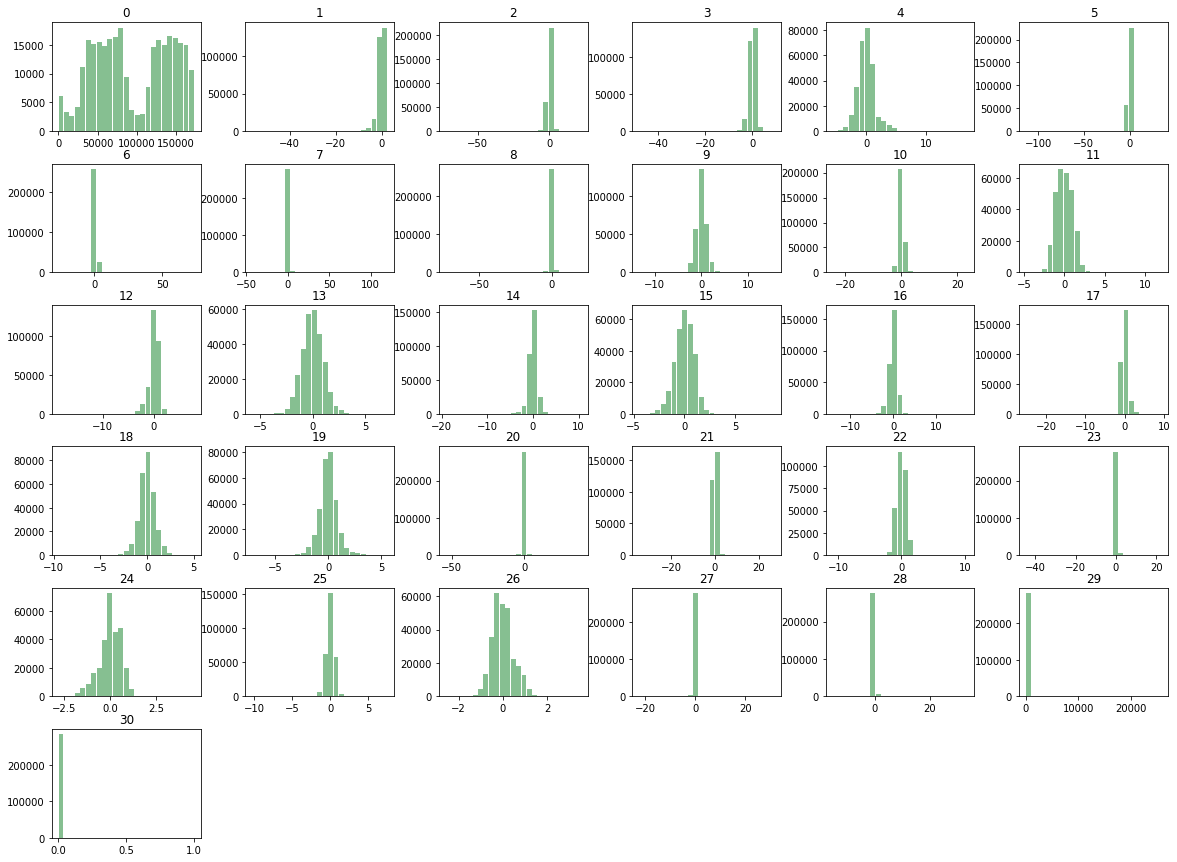

In [ ]:
numcolanalysis(df)

       Time        12        14        17    Amount   30
0 -0.994983 -0.617801 -0.311169  0.207971  1.783274  0.0
1 -0.994983  1.065235 -0.143772 -0.114805 -0.269825  0.0


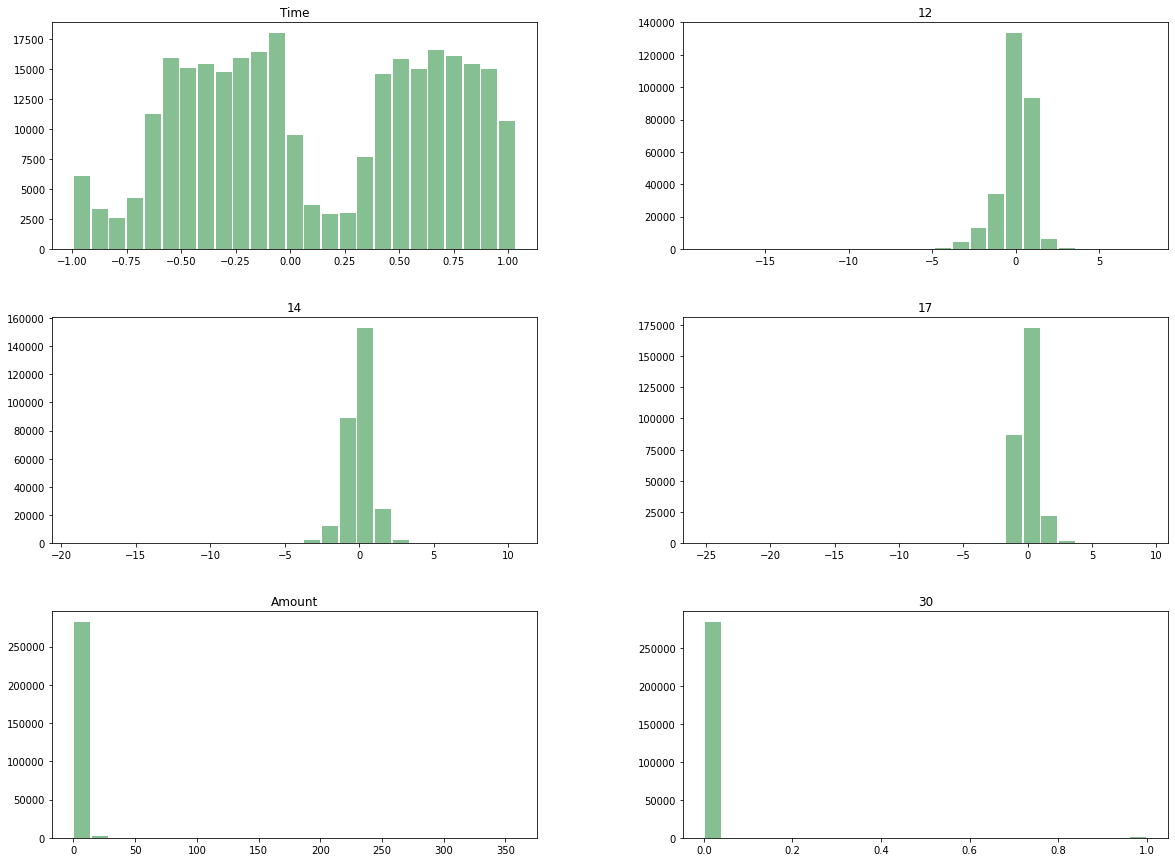

In [ ]:
# calling scale function and sending column index in argument
scale_cols=[0,29]
df = get_scaled_df(df,scale_cols)

# removing useless columns
remove_cols=[1,2,3,4,5,6,7,8,9,10,11,13,15,16,18,19,20,21,22,23,24,25,26,27,28]
drop_useless_columns(df,remove_cols)

# Viewing data after manipulations
print(df.head(2))
numcolanalysis(df)

## **NUTS Sampling**
* Since we have no prior knowledge about these parameters, we can assume that it could be anything.
* First, I have implemented NUTS Sampling. As we have seen that our time histogram disribution is multimodal therefore, I have used Gaussian mixture model to capture the peaks in the form of clusters.
* Then for amount, I have used Uniform distribution from 0 to 100 limit set in  order to cach the values in between.
* Next, I have used Normal distribution for column 12 and 17, also just to explore the impact of distribution I have used SkewNormal for sigma distribution.
* Lastly, due to resources contraints, I chose only 100 draws with two steps: Elemwise for Categorical Sampling and NUTS for remaining variables.

**Summary**

* If you check the summary, you will see that there are numerous divergences which is not as it shows that the simulated trajectory is departed from the true trajectory. 
* Since, we have a large dataset and for that number of draws should be atleast greater than 100 in order to cover more data and make plausible estimations  as this process has hardly covered 10% of the entire data however, within time and resources, I could not exceed my draws. 

**Convergence Diagnosis**
* To diagnose convergence, I have used trace and forest plot after which my session got expired.
* From trace plot, we can witness the divergences in all plots which are on the right side. Also, we can say that the caterpillar is not fuzzy.
* Similarly from left plots, it is evident that the chains are hardly overlapping on each other.
* From forest plot wih 94% HDI, we can see few variables are centered while few of them are spread across the mean.

In [ ]:
# converting it into simple arrays
y_simple = df[30]
x_amount = df['Amount'].values
x_17 = df[17].values
x_12 = df[12].values
x_time = df['Time'].values

In [ ]:
with pm.Model() as simple_model:
  
  #Time
# cluster sizes
  p = pm.Dirichlet("p", a=np.array([10.0, 5.0, 2.0]), shape=3)
# ensure all clusters have some points
  p_min_potential = pm.Potential("p_min_potential", T.tensor.switch(T.tensor.min(p) < 0.1, -np.inf, 0))

# cluster centers
  means = pm.Normal("means", mu=[0, 0, 0], sigma=0.5, shape=3)
 # measurement error
  sd = pm.Uniform("sd", lower=0, upper=10)
 # latent cluster of each observation
  category = pm.Categorical("category", p=p)
# likelihood for each observed value
  t_obs = pm.Normal("t_obs", mu=means[category], sigma=sd, observed=y_simple)
  # df_time = pm.NormalMixture("df_time", w, mu, tau=tau, observed=y_simple)

  #Amount
  # define priors
  amount_mu = pm.Uniform('amount_mu', lower=0, upper=100)
  amount_sigma = pm.Uniform('amount_sigma', lower=10, upper=100)
  # define likelihood
  X_amount = pm.Normal('x_amount', mu=amount_mu, sd=amount_sigma, observed=y_simple)

  # 2 other features
  # Priors for 
  alpha_x = pm.Normal("alpha_x", mu=0, sigma=10)
  beta_x = pm.Normal("beta_x", mu=0, sigma=10, shape=2)
  sigma_x = pm.HalfNormal("sigma_x", sigma=10)
  # Expected value of outcome
  mu_x = (alpha_x + beta_x[0] * x_17 + beta_x[1] * x_12)
  # Likelihood (sampling distribution) of observations
  X_obs = pm.SkewNormal("X_obs", mu=mu_x, sigma=sigma_x, alpha=2, observed=y_simple)

  #Sampling ------ NUTS
  step1 = pm.NUTS(vars=[sigma_x, beta_x, alpha_x, amount_sigma, amount_mu, sd, means, p])
  step2 = pm.ElemwiseCategorical(vars=[category], values=[0, 1, 2])
  sample_nuts = pm.sample(draws=100, step=[step1, step2])

az.summary(sample_nuts)
# az.plot_trace(sample_nuts, var_names=["p", "sd", "means", "category", "amount_mu", "sigma_x", "beta_x", "alpha_x" ]);

Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [p, means, sd, amount_mu, amount_sigma, alpha_x, beta_x, sigma_x]
>ElemwiseCategorical: [category]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 10800 seconds.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8941773466460454, but should be close to 0.8. Try to increase the number of tuning steps.
There were 161 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
means[0],0.002,0.000,0.002,0.002,0.000,0.000,93.0,97.0,1.04
means[1],-0.009,0.392,-0.698,0.640,0.058,0.041,44.0,91.0,1.07
means[2],0.049,0.553,-1.142,0.967,0.064,0.055,75.0,94.0,1.01
category,0.080,0.323,0.000,1.000,0.027,0.019,128.0,122.0,1.00
alpha_x,-0.021,0.000,-0.021,-0.021,0.000,0.000,80.0,64.0,1.03
beta_x[0],-0.008,0.000,-0.009,-0.008,0.000,0.000,98.0,44.0,1.03
beta_x[1],-0.005,0.000,-0.005,-0.005,0.000,0.000,105.0,138.0,1.05
p[0],0.566,0.093,0.404,0.739,0.021,0.015,19.0,35.0,1.10
p[1],0.267,0.101,0.105,0.452,0.022,0.016,18.0,33.0,1.12
p[2],0.167,0.058,0.100,0.289,0.007,0.005,58.0,103.0,1.01


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e00bd19d0>,
      dtype=object)

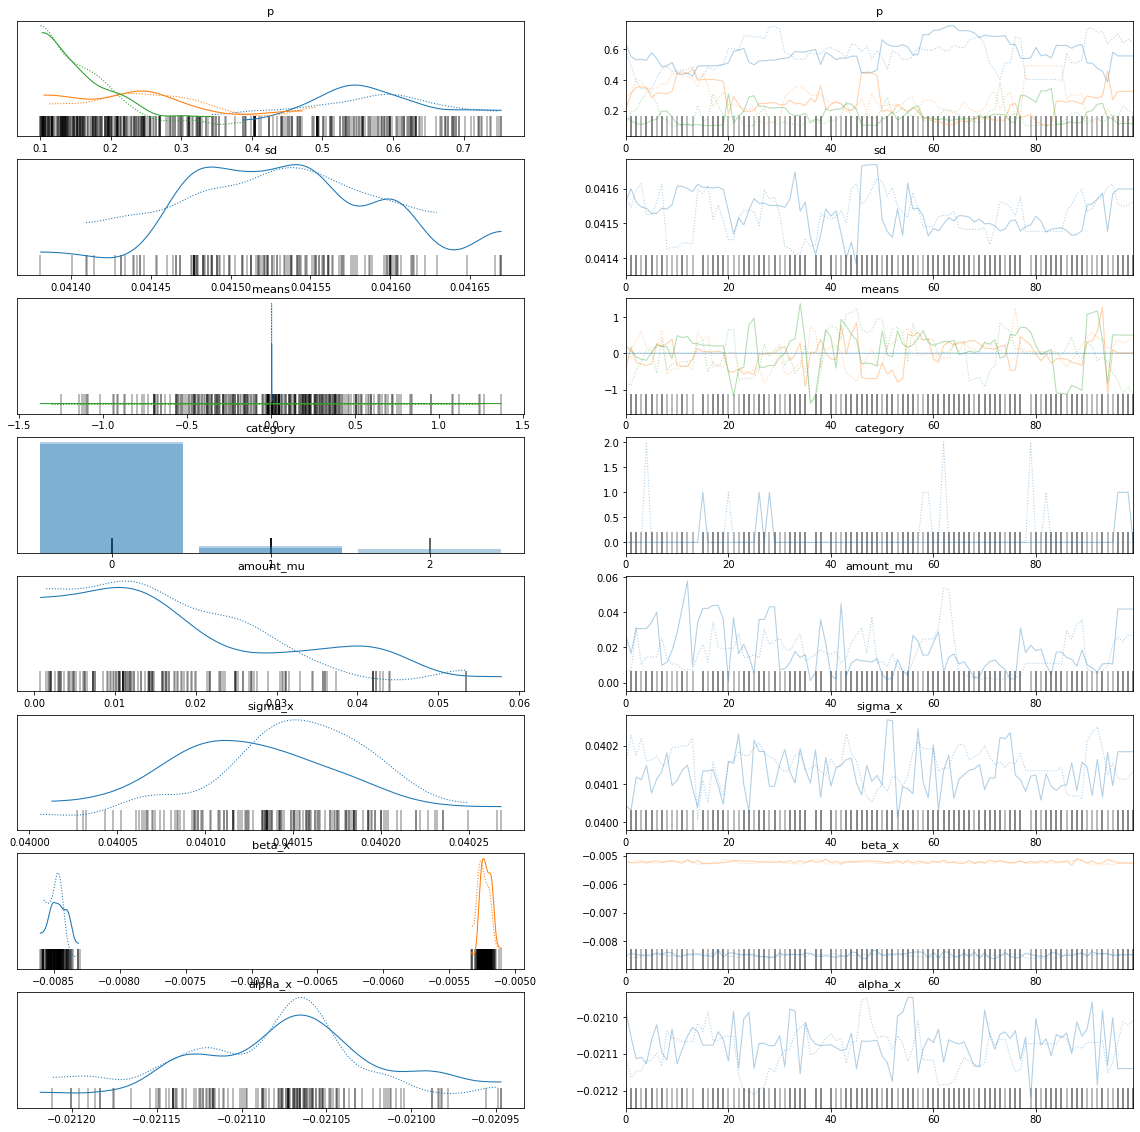

In [ ]:
az.plot_trace(sample_nuts, var_names=["p", "sd", "means", "category", "amount_mu", "sigma_x", "beta_x", "alpha_x"], figsize=(20,20))

Got error No model on context stack. trying to find log_likelihood in translation.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e029f3ed0>],
      dtype=object)

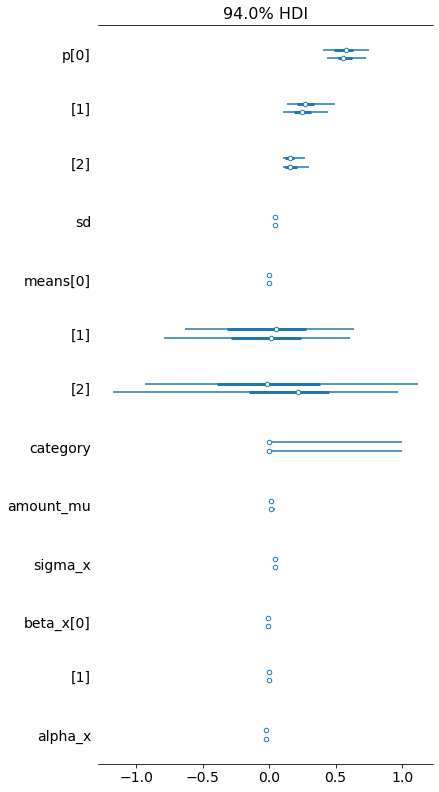

In [ ]:
az.plot_forest(sample_nuts,var_names=["p", "sd", "means", "category", "amount_mu", "sigma_x", "beta_x", "alpha_x"])

## **NUTS Sampling with Logistic Regression on an Individual Feature "Amount"**
* Here, I have implementted Logistic Regression just one on variable to explore how it works. It separates the amount with respect to the target class.
* Below given, the plot shows non subscription vs. subscription (y = 0, y = 1). The S-shaped (green) line is the mean value of θ. This line can be interpreted as the probability of a subscription, given that we know that the last time contact duration(the value of the duration). The boundary decision is represented as a (black) vertical line. According to the boundary decision, the values of duration to the left correspond to y = 0 (non subscription), and the values to the right to y = 1 (subscription).
* From that, we can assume that most of the data is subscribed as it is on the right side however, it could not separate fraud and non-fraud data.

In [ ]:
y_simple = df[30]
x_n = 12 
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()
a_0 = df['Amount'].values
a_c = a_0 - a_0.mean()

with pm.Model() as model_simple:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    
    μ = α + pm.math.dot(x_c, β)    
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    
    y_1 = pm.Bernoulli('y_1', p=θ, observed=y_simple)

    trace_simple = pm.sample(100, tune=1000)

The above plot shows non subscription vs. subscription (y = 0, y = 1).
The S-shaped (green) line is the mean value of θ. This line can be interpreted as the probability of a subscription, given that we know that the last time contact duration(the value of the duration).
The boundary decision is represented as a (black) vertical line. According to the boundary decision, the values of duration to the left correspond to y = 0 (non subscription), and the values to the right to y = 1 (subscription).

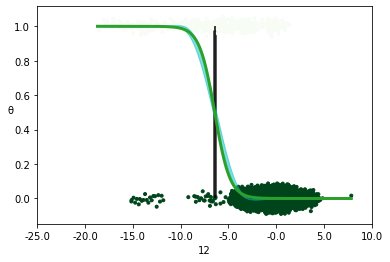

In [ ]:

theta = trace_simple['θ'].mean(axis=0)
idx = np.argsort(x_c)
plt.plot(x_c[idx], theta[idx], color='C2', lw=3)
plt.vlines(trace_simple['bd'].mean(), 0, 1, color='k')
bd_hpd = az.hdi(trace_simple['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)

plt.scatter(x_c, np.random.normal(y_simple, 0.02),
            marker='.', c=y_simple, cmap="Greens_r")
az.plot_hdi(x_c, trace_simple['θ'], color='c')

plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1));

In [ ]:
ppc = pm.sample_posterior_predictive(trace_simple, model=model_simple, samples=500)
preds = np.rint(ppc['y_1'].mean(axis=0)).astype('int')
print('Accuracy of the simplest model:', accuracy_score(preds, df[30]))
print('f1 score of the simplest model:', f1_score(preds, df[30]))

Accuracy of the simplest model: 0.9988448317632642
f1 score of the simplest model: 0.55359565807327


## **NUTS Sampling using GLM**

Here, I have used Generalized Linear Model, there are 3 components to any GLM: 
- Random Component – refers to the probability distribution of the response variable (Y); e.g. normal distribution for Y in the linear regression, or binomial distribution for Y in the binary logistic regression. 
- Systematic Component - specifies the explanatory variables  in the model, more specifically their linear combination in creating the so called linear predictor.
Link Function,  or  - specifies the link between random and systematic components. It says how the expected value of the response relates to the linear predictor of explanatory variables.
* Here, I didn't choose the link function manually. With 1000 draws, GLM has given very good results. 

**Convergence Diagnosis**

* If you check the summary, you will see that there are no divergences which is good. Then, r_hat score is equal to 1. 
* To diagnose convergence, I have used trace, forest, density, autocorrelaion and energy plots. From all these plots, we can say that posterior mean is closer to zero. Overlapping can be witnessed a few intervals which means that model worked but not given 100% results.
* Infact, if I would have increased number of draws as we have a large dataset and 1000 is very small part of it then each of the predictor could have covered more data and given better results.
* Lastly, the confusion metric has shown good results, with a very small percentage of "True Positives" which is true because we have very few fraudulent cases in dataset. Same results obtained from ppc plot: majority of the predicted values lie in class-0.

In [ ]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('df[30] ~ Time + Amount + df[12]+ df[14] + df[17]', df, family = pm.glm.families.Binomial())
    trace = pm.sample(100, tune = 1000, init = 'adapt_diag')

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [df[17], df[14], df[12], Amount, Time, Intercept]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 1511 seconds.


In [ ]:
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-8.035,0.108,-8.241,-7.851,0.008,0.006,174.0,157.0,1.00
Time,0.281,0.146,-0.005,0.486,0.010,0.008,206.0,120.0,1.01
Amount,-0.003,0.009,-0.018,0.018,0.001,0.001,256.0,105.0,1.00
df[12],-0.532,0.057,-0.630,-0.438,0.005,0.003,152.0,112.0,1.01
df[14],-0.839,0.037,-0.904,-0.769,0.003,0.002,199.0,124.0,1.01
df[17],-0.098,0.030,-0.156,-0.048,0.002,0.002,168.0,187.0,1.00


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


trace plot


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


posterior plot


Got error No model on context stack. trying to find log_likelihood in translation.


forest plot


Got error No model on context stack. trying to find log_likelihood in translation.


autocorr plot


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


density plot


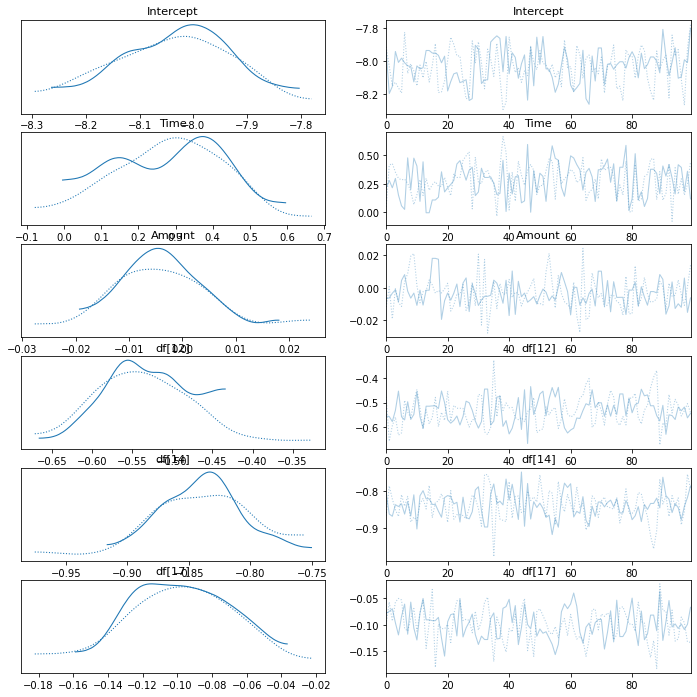

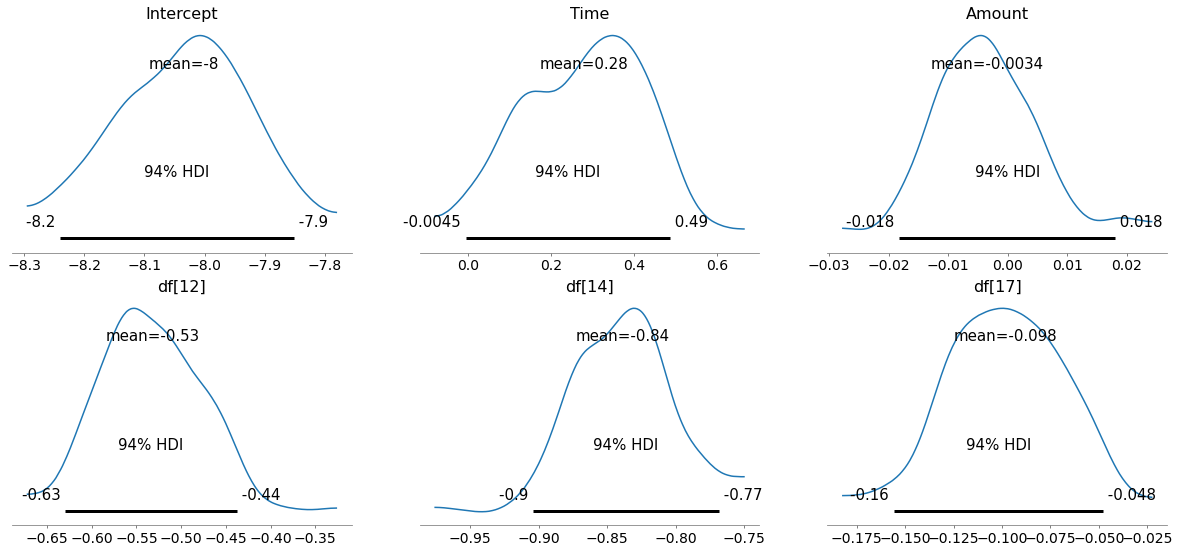

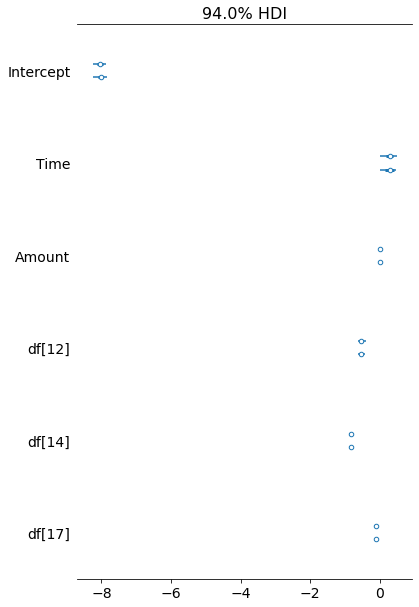

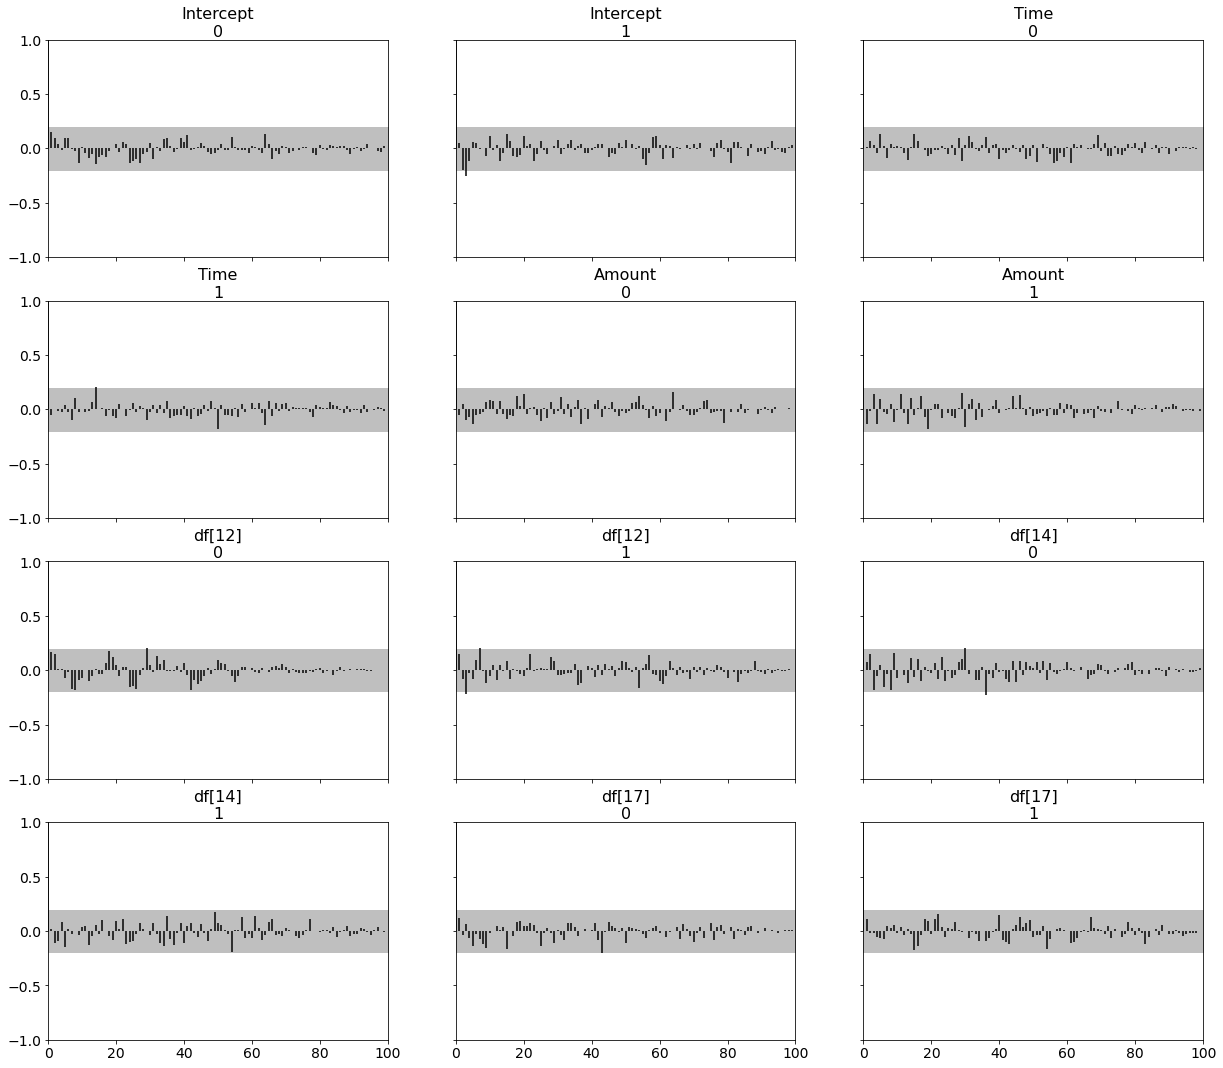

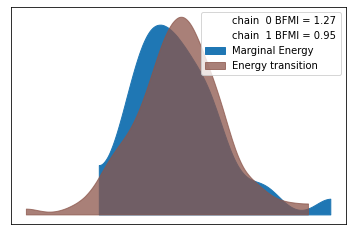

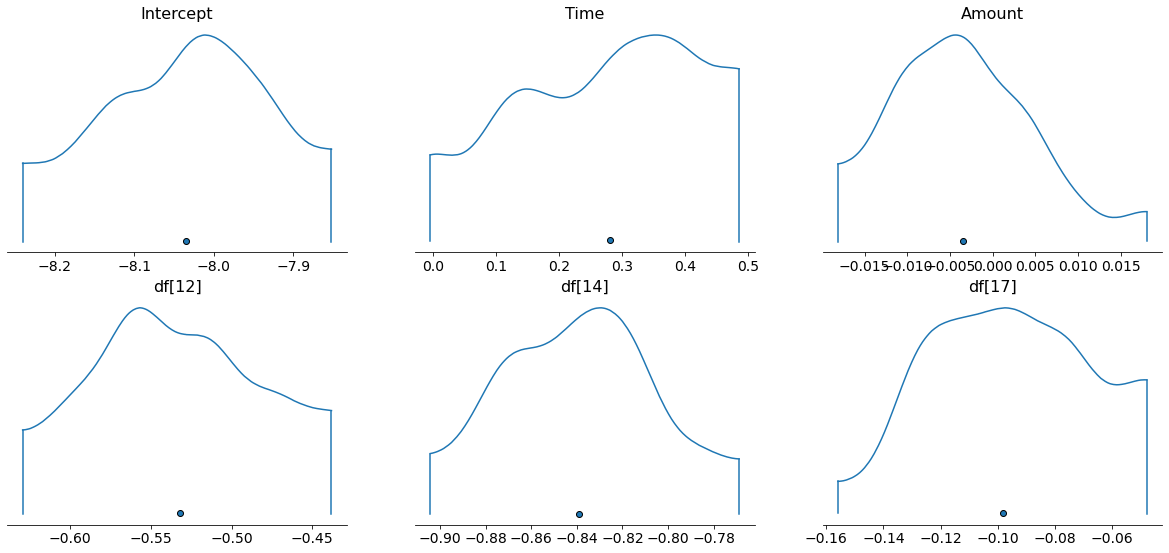

In [ ]:
plots(trace)

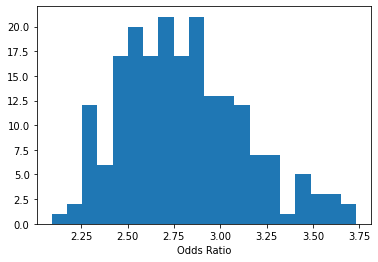

In [ ]:
b = trace['Time']
plt.hist(np.exp(b), bins=20)
plt.xlabel("Odds Ratio")
plt.show();

Confusion matrix
[[284271     44]
 [   209    283]]


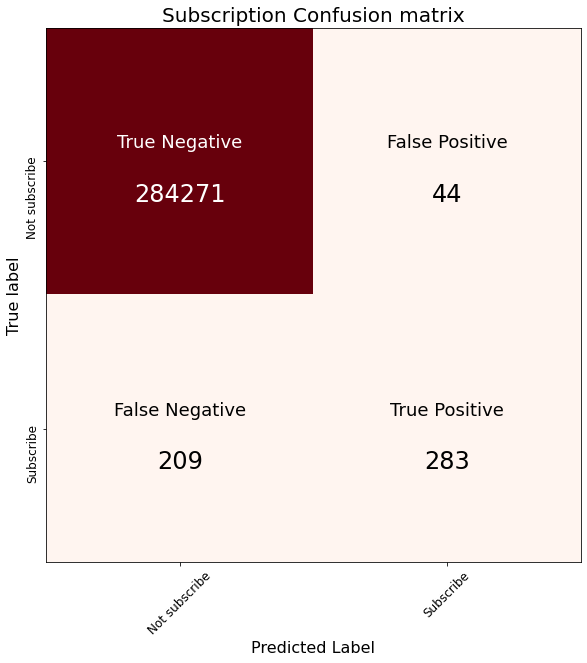

In [ ]:
ppc = pm.sample_posterior_predictive(trace, model=logistic_model, samples=500)
preds = np.rint(ppc['y'].mean(axis=0)).astype('int')

def plot_confusion_matrix(cm, classes = ['Not subscribe', 'Subscribe'],
                          title='Subscription Confusion matrix',
                          cmap=plt.cm.Reds):
    
    # Display the matrix in text form
    print('Confusion matrix')
    print(cm)
    plt.figure(figsize = (8,10))
    # Show the matrix using the imshow functionality
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 20)
    
    # Tick marks show classes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 12)
    plt.yticks(tick_marks, classes, rotation = 90, size = 12)

    # Formatting for text labels on plot
    fmt1 = 's'
    fmt2 = 'd'
    thresh = cm.max() / 2.
    
    # Four types of classifications
    types = [['True Negative', 'False Positive'],
             ['False Negative', 'True Positive']]
    
    # Add the actual numbers and the types onto the heatmap plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i - 0.05, format(types[i][j], fmt1),
                 horizontalalignment="center", size = 18,
                 color="white" if cm[i, j] > thresh else "black")
        
        plt.text(j, i + 0.15, format(cm[i, j], fmt2),
                 horizontalalignment="center", size = 24,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    
    plt.ylabel('True label', size = 16)
    plt.xlabel('Predicted Label', size = 16)
    
cm = confusion_matrix(df[30], preds)
plot_confusion_matrix(cm)

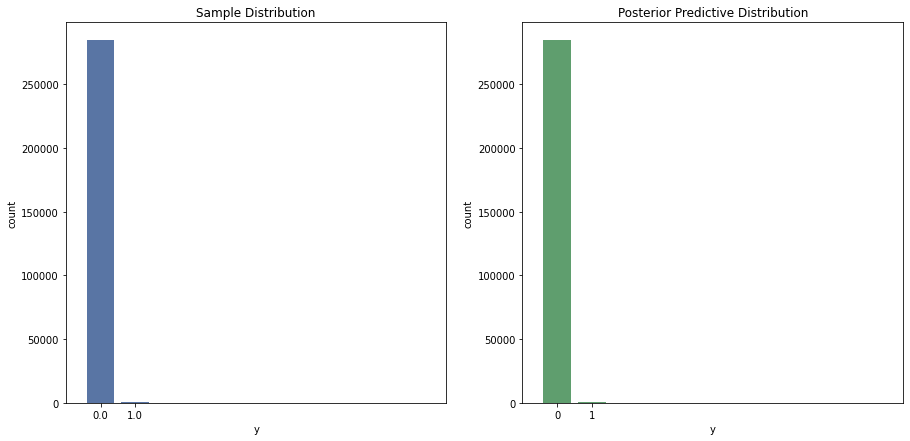

In [ ]:
with logistic_model:
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
  sns.countplot(x=df[30], color=sns_c[0], ax=ax[0])
  ax[0].set(title='Sample Distribution', xlabel='y', xlim=(-1, 10))
  sns.countplot(x=preds, color=sns_c[2], ax=ax[1])
  ax[1].set(title='Posterior Predictive Distribution', xlabel='y', xlim=(-1, 10));

## **Metropolis Hasting Sampling**

**Convergence Diagnosis**
* Here, I have implemented same model I used for NUTS sampling, but unfortunately, I have got worse results.
* Again due to time constraints I selected only 100 draws. 
* The model didn't converge while no divergence as well.
r-hat score was very high predictor 12 and 17. If I would have increased number of draws as we have a large dataset and 100 is extremely a small part of it then each of the predictor could have covered more data and given better results.
* Trace plot has shown that model couldn't find its way at all. 
* ppc plot of Amount feature has also depicted the wrong posterior prediction from the true values.

In [ ]:
# Setting predictor variables
x_amount = df['Amount'].values
x_17 = df[17].values
x_12 = df[12].values
# Observations are the indicator
df_obs = np.array(df.loc[:, 30])

In [ ]:
with pm.Model() as mh_model1:
  
   #Amount
  # define priors
  amount_mu = pm.Uniform('amount_mu', lower=0, upper=100)
  amount_sigma = pm.Uniform('amount_sigma', lower=10, upper=100)
  # define likelihood
  X_amount = pm.Normal('x_amount', mu=amount_mu, sd=amount_sigma, observed=df_obs)

  # 2 other features
  # Priors for 
  alpha_x = pm.Normal("alpha_x", mu=0, sigma=10)
  beta_x = pm.Normal("beta_x", mu=0, sigma=10, shape=2)
  sigma_x = pm.HalfNormal("sigma_x", sigma=10)
  # Expected value of outcome
  mu_x = (alpha_x + beta_x[0] * x_17 + beta_x[1] * x_12)
  # Likelihood (sampling distribution) of observations
  X_obs = pm.SkewNormal("X_obs", mu=mu_x, sigma=sigma_x, alpha=2, observed=df_obs)

  #Sampling ------ NUTS
  step1 = pm.Metropolis(vars=[sigma_x, beta_x, alpha_x, amount_sigma, amount_mu])
  sample_mh = pm.sample(draws=100, step=step1)

az.summary(sample_mh)

Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [amount_mu]
>Metropolis: [amount_sigma]
>Metropolis: [alpha_x]
>Metropolis: [beta_x]
>Metropolis: [sigma_x]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 682 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_x,-0.022,0.001,-0.024,-0.021,0.001,0.001,2.0,2.0,3.04
beta_x[0],-0.004,0.004,-0.009,0.000,0.003,0.002,3.0,30.0,2.50
beta_x[1],-0.003,0.003,-0.005,0.000,0.002,0.001,2.0,5.0,3.02
amount_mu,0.016,0.011,0.001,0.035,0.002,0.001,27.0,19.0,1.08
amount_sigma,10.000,0.000,10.000,10.000,0.000,0.000,16.0,24.0,1.12
sigma_x,0.041,0.001,0.040,0.043,0.001,0.001,3.0,16.0,2.28


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcb91745110>,
      dtype=object)

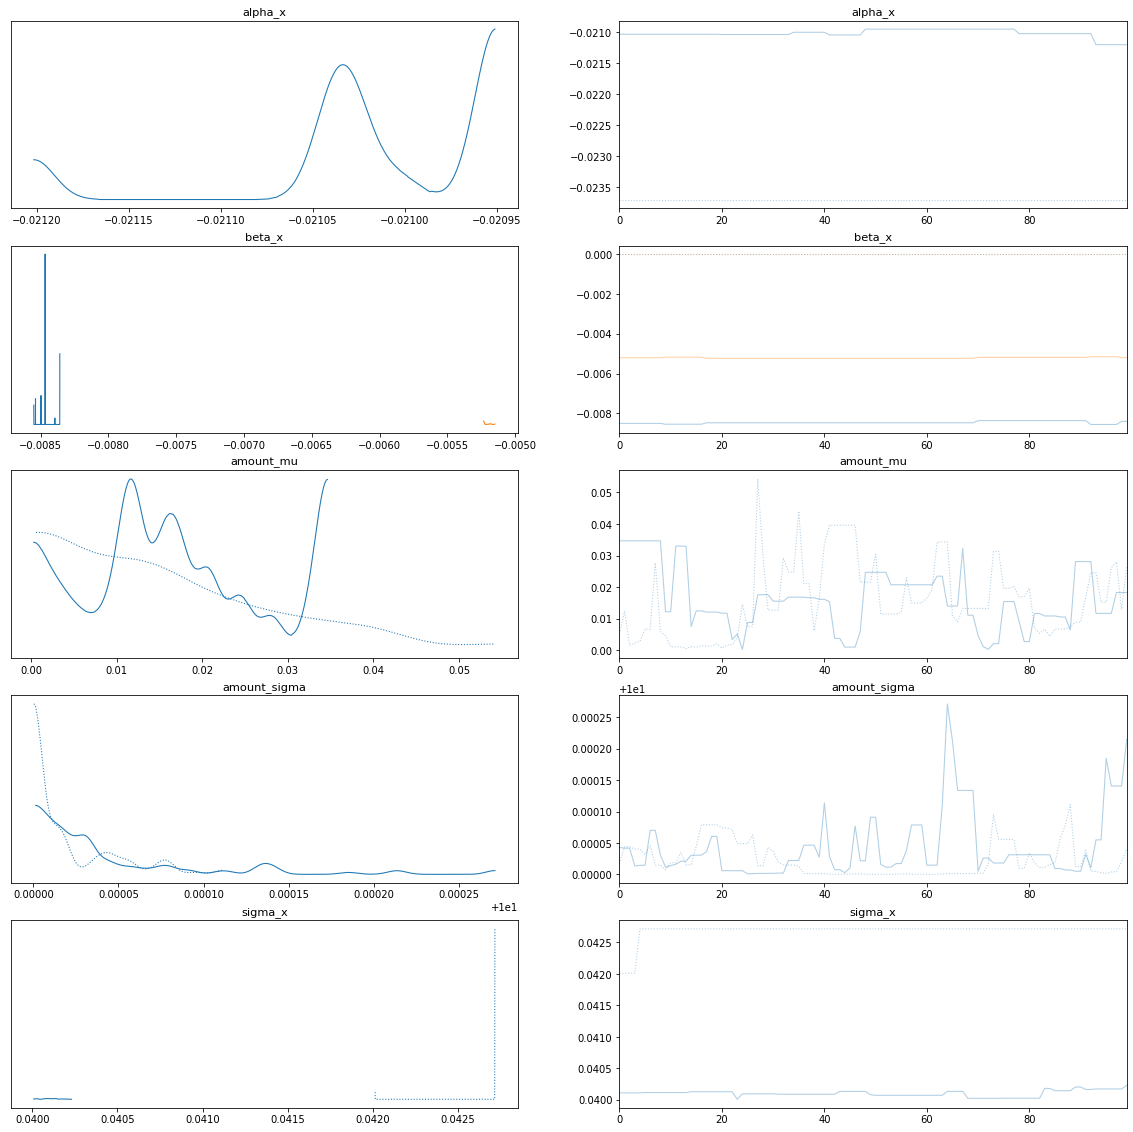

In [ ]:
az.plot_trace(sample_mh, figsize=(20,20))

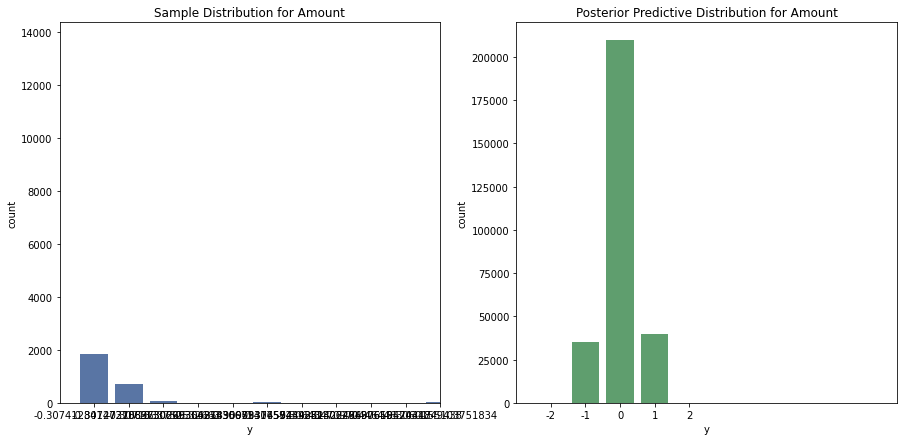

In [ ]:
with mh_model1:
  ppc = pm.sample_posterior_predictive(sample_mh, model=mh_model1, samples=500)
  
preds = np.rint(ppc['x_amount'].mean(axis=0)).astype('int')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
sns.countplot(x=df['Amount'].values, color=sns_c[0], ax=ax[0])
ax[0].set(title='Sample Distribution for Amount', xlabel='y', xlim=(-1, 10))
sns.countplot(x=preds, color=sns_c[2], ax=ax[1])
ax[1].set(title='Posterior Predictive Distribution for Amount', xlabel='y', xlim=(-1, 10));

## **Hamiltonian MC Sampling**

**Convergence Diagnosis**

* Here, I have implemented the same model I used for NUTS and to my surprise Hamiltonian worked better then NUTS and Metropolis Hasting though it was extremely slow. 
* The number of effective samples is smaller than 25% for some parameters.
* Again due to time constraints I selected only 100 draws.
The acceptance probability does not match the target. It is 0.898395030585099, but should be close to 0.65.
* For which, it is my assumpion that if I could have increased number of draws, I would have achieved 100% accuracy.
* The r-hat score in all variables is ~1.
* All trace, auto-correlation and forest plot have shown good results. 
* The mean is closer to 0.
* Fuzzy caterpillars and chains are trying to overlap each other and have achieved some success with the neglibile amount used for sampling.
.

In [ ]:
# setting predictors and indicator
y_simple = df[30]
x_amount = df['Amount'].values
x_17 = df[17].values
x_12 = df[12].values
x_time = df['Time'].values

In [ ]:
with pm.Model() as hmc_model:
  
  #Amount
  # define priors
  amount_mu = pm.Uniform('amount_mu', lower=0, upper=100)
  amount_sigma = pm.Uniform('amount_sigma', lower=10, upper=100)
  # define likelihood
  X_amount = pm.Normal('x_amount', mu=amount_mu, sd=amount_sigma, observed=y_simple)

  # 3 other features
  # Priors for 
  alpha_x = pm.Normal("alpha_x", mu=0, sigma=10)
  beta_x = pm.Normal("beta_x", mu=0, sigma=10, shape=2)
  sigma_x = pm.HalfNormal("sigma_x", sigma=10)
  # Expected value of outcome
  mu_x = (alpha_x + beta_x[0] * x_17 + beta_x[1] * x_12)
  # Likelihood (sampling distribution) of observations
  X_obs = pm.SkewNormal("X_obs", mu=mu_x, sigma=sigma_x, alpha=2, observed=y_simple)

  #Sampling ------ NUTS
  step1 = pm.HamiltonianMC(vars=[sigma_x, beta_x, alpha_x, amount_sigma, amount_mu])
  sample_hmc = pm.sample(draws=100, tune=100, step=[step1])

az.summary(sample_hmc)
# az.plot_trace(sample_nuts, var_names=["p", "sd", "means", "category", "amount_mu", "sigma_x", "beta_x", "alpha_x" ]);

Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
HamiltonianMC: [amount_mu, amount_sigma, alpha_x, beta_x, sigma_x]


Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 16854 seconds.
The acceptance probability does not match the target. It is 0.898395030585099, but should be close to 0.65. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8396227104611728, but should be close to 0.65. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_x,-0.021,0.000,-0.021,-0.021,0.000,0.000,191.0,183.0,1.01
beta_x[0],-0.008,0.000,-0.009,-0.008,0.000,0.000,266.0,151.0,1.00
beta_x[1],-0.005,0.000,-0.005,-0.005,0.000,0.000,266.0,86.0,1.04
amount_mu,0.019,0.011,0.000,0.038,0.002,0.001,30.0,27.0,1.05
amount_sigma,10.000,0.000,10.000,10.000,0.000,0.000,41.0,86.0,1.02
sigma_x,0.040,0.000,0.040,0.040,0.000,0.000,168.0,77.0,1.01


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f692994b810>,
      dtype=object)

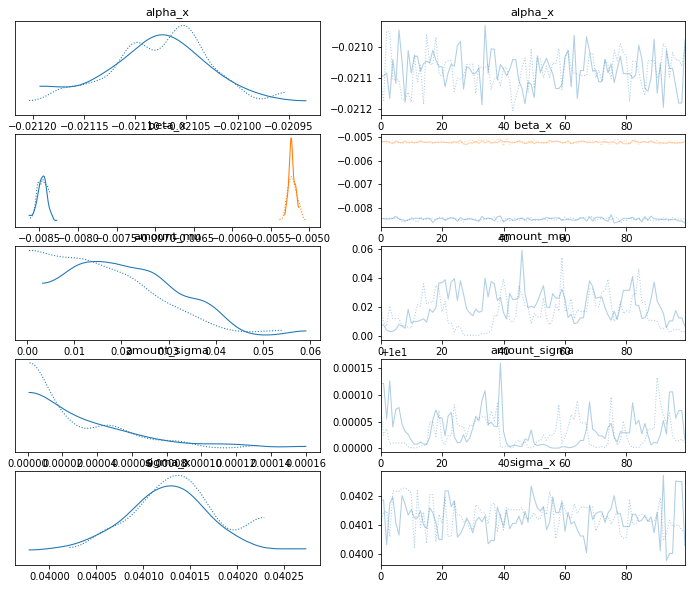

In [ ]:
az.plot_trace(sample_hmc)

Got error No model on context stack. trying to find log_likelihood in translation.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f693acfd4d0>],
      dtype=object)

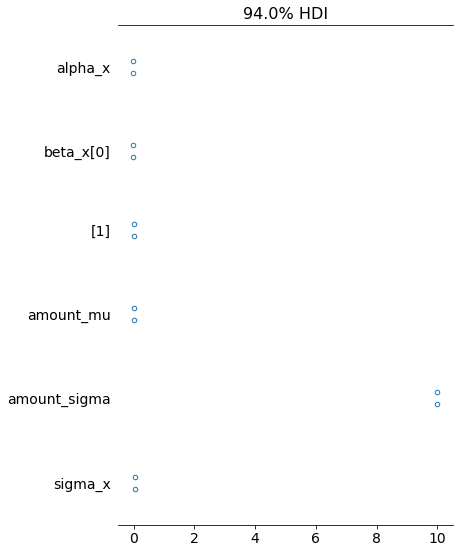

In [ ]:
az.plot_forest(sample_hmc)

Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6927cc5c10>,
      dtype=object)

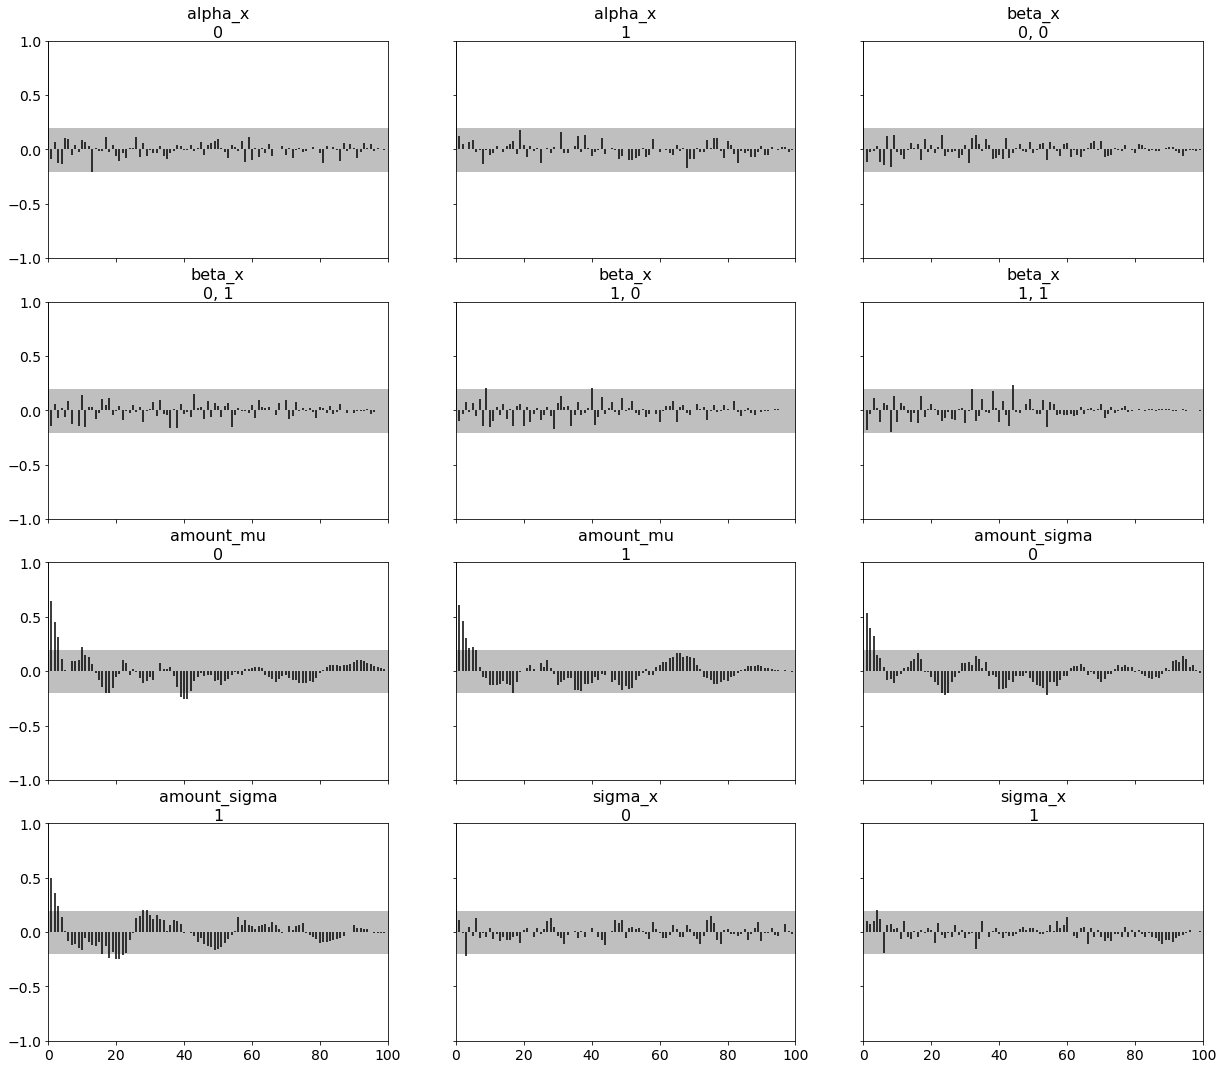

In [ ]:
az.plot_autocorr(sample_hmc)